<a href="https://colab.research.google.com/github/rezharama/Pemrograman-Citra-Digital-Latihan-1/blob/master/Tugas_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nama : Reza Wisnu Pratama**
**NIM  : 17.01.53.0022**

**Tugas Kecerdasan Buatan**

# **Image Captioning**

Untuk mencapainya akan menggunakan model attention-based, yang memungkinkan kita melihat bagian gambar mana yang menjadi fokus model saat menghasilkan caption/keterangan.

**Contoh proses prediksi caption** (https://tensorflow.org/images/imcap_prediction.png)

Arsitektur modelnya mirip dengan **Show, Attend and Tell: Neural Image Caption Generation with Visual Attention** (https://arxiv.org/abs/1502.03044).

Notebook ini adalah contoh end-to-end. Saat menjalankan notebook, notebook akan mendownload kumpulan data **[MS-COCO]** (http://cocodataset.org/#home), memproses dan menyimpan dalam cache subset gambar menggunakan Inception V3, melatih model encoder-decoder, dan membuat teks di gambar baru menggunakan model terlatih.

Dalam contoh ini, Anda akan melatih model pada jumlah data yang relatif kecil — **30.000 teks pertama untuk sekitar 20.000 gambar** (karena ada beberapa teks per gambar dalam kumpulan data).

In [1]:
#import model yang diperlukan

import tensorflow as tf

# KIta akan menghasilkan plot perhatian untuk melihat bagian mana dari sebuah gambar
# fokus model selama pembuatan teks
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Unduh dan siapkan dataset MS-COCO

Kita akan menggunakan [MS-COCO dataset] (http://cocodataset.org/#home) untuk melatih model kita. Dataset berisi lebih dari 82.000 gambar, yang masing-masing memiliki setidaknya 5 anotasi teks berbeda. Kode di bawah mengunduh dan mengekstrak kumpulan data secara otomatis.

**Perhatian: unduhan besar**. Kita akan menggunakan training set, yaitu file 13GB.

In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 325s 0us/step


## Opsional: batasi ukuran set pelatihan
Untuk mempercepat pelatihan kita akan menggunakan subset dari 30.000 teks dan gambarnya yang sesuai untuk melatih model. Memilih untuk menggunakan lebih banyak data akan menghasilkan kualitas teks yang lebih baik.

In [3]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [4]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [5]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Pilih 6000 image_paths pertama dari set yang diacak.
# Kira-kira setiap id gambar memiliki 5 teks yang terkait dengannya, jadi itu akan mengarah ke 30.000 contoh.

train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [6]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A picture of a scooter and bicycles in front of a game room. <end>


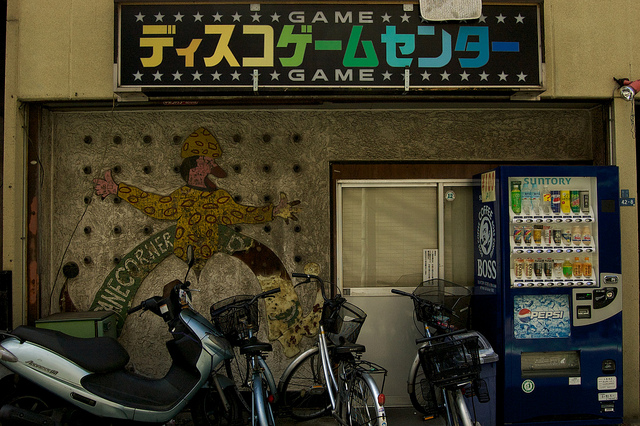

In [7]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Proses awal gambar menggunakan InceptionV3
Selanjutnya, Anda akan menggunakan InceptionV3 (yang dilatih sebelumnya di Imagenet) untuk mengklasifikasikan setiap gambar. Anda akan mengekstrak fitur dari lapisan konvolusional terakhir.

Pertama, Anda akan mengonversi gambar ke dalam format yang diharapkan InceptionV3 dengan:
* Mengubah ukuran gambar menjadi 299px kali 299px
* [Proses praproses gambar] (https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) menggunakan [preprocess_input] (https://www.tensorflow.org/api_docs/python/tf / keras / application / inception_v3 / preprocess_input) untuk menormalkan gambar agar berisi piksel dalam rentang -1 hingga 1, yang cocok dengan format gambar yang digunakan untuk melatih InceptionV3.

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Inisialisasi InceptionV3 dan muat bobot Imagenet yang telah dilatih sebelumnya

Sekarang kita akan membuat model tf.keras di mana lapisan keluaran adalah lapisan konvolusional terakhir dalam arsitektur InceptionV3. Bentuk keluaran dari layer ini adalah `` 8x8x2048```. Kita menggunakan lapisan konvolusional terakhir karena Anda menggunakan perhatian dalam contoh ini. Kita tidak melakukan inisialisasi ini selama pelatihan karena dapat menjadi hambatan.

* Kita meneruskan setiap gambar melalui jaringan dan menyimpan vektor yang dihasilkan dalam kamus (image_name -> feature_vector).
* Setelah semua gambar melewati jaringan, Anda menyimpan kamus ke disk.

In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


## Cache fitur yang diekstrak dari InceptionV3

KIta akan memproses terlebih dahulu setiap gambar dengan InceptionV3 dan menyimpan output ke cache. Meng-cache output dalam RAM akan lebih cepat tetapi juga intensif memori, membutuhkan 8 \ * 8 \ * 2048 float per gambar. Pada saat penulisan, ini melebihi batasan memori Colab (saat ini memori 12GB).

Performa dapat ditingkatkan dengan strategi cache yang lebih canggih (misalnya, dengan memecah gambar untuk mengurangi I / O disk akses acak), tetapi itu akan membutuhkan lebih banyak kode.

Caching akan memakan waktu sekitar 10 menit untuk dijalankan di Colab dengan GPU. Jika Anda ingin melihat bilah kemajuan, Anda dapat:

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Ubah baris berikut:

    `for img, path in image_dataset:`

    ke:

    `for img, path in tqdm(image_dataset):`


In [10]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Proses praproses dan tokenize teks

* Pertama, Kita akan memberi token pada teks (misalnya, dengan membagi spasi). Ini memberi kita kosakata dari semua kata unik dalam data (misalnya, "berselancar", "sepak bola", dan sebagainya).
* Selanjutnya, Kita akan membatasi ukuran kosakata hingga 5.000 kata teratas (untuk menghemat memori). Kita akan mengganti semua kata lain dengan token "UNK" (UNKNOWN).
* Kita kemudian membuat pemetaan kata-ke-indeks dan indeks-ke-kata.
* Terakhir, Kita memasukkan semua urutan agar memiliki panjang yang sama dengan yang terpanjang.

In [11]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [12]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [13]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [14]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [15]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [16]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [17]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [18]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24011, 24011, 6002, 6002)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [19]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [20]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fakta menarik: dekoder di bawah ini identik dengan yang ada di contoh untuk [Terjemahan Mesin Neural dengan Perhatian] (../ sequences / nmt_with_attention.ipynb).

Arsitektur model terinspirasi oleh makalah [Show, Attend and Tell] (https://arxiv.org/pdf/1502.03044.pdf).

* Dalam contoh ini, KIta mengekstrak fitur dari lapisan konvolusional bawah InceptionV3 yang memberi kita vektor bentuk (8, 8, 2048).
* Kita mengecilkan menjadi bentuk (64, 2048).
* Vektor ini kemudian diteruskan melalui Encoder CNN (yang terdiri dari satu lapisan yang terhubung sepenuhnya).
* RNN (di sini GRU) hadir di atas gambar untuk memprediksi kata berikutnya.

In [22]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [23]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [24]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [25]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint


In [27]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [28]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Pelatihan

* Kita mengekstrak fitur yang disimpan dalam file `.npy` masing-masing dan kemudian meneruskan fitur tersebut melalui encoder.
* Output encoder, status tersembunyi (diinisialisasi ke 0) dan input decoder (yang merupakan token awal) diteruskan ke decoder.
* Dekoder mengembalikan prediksi dan status tersembunyi dekoder.
* Status tersembunyi decoder kemudian diteruskan kembali ke model dan prediksi digunakan untuk menghitung kerugian.
* Gunakan Teacher forcing untuk memutuskan masukan berikutnya ke decoder.
* Teacher forcing adalah teknik di mana kata target diteruskan sebagai masukan berikutnya ke decoder.
* Langkah terakhir adalah menghitung gradien dan menerapkannya ke pengoptimal dan propagasi mundur.

In [29]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [30]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [31]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9538
Epoch 1 Batch 100 Loss 1.0567
Epoch 1 Batch 200 Loss 0.9556
Epoch 1 Batch 300 Loss 0.8658
Epoch 1 Loss 1.032393
Time taken for 1 epoch 139.53 sec

Epoch 2 Batch 0 Loss 0.8442
Epoch 2 Batch 100 Loss 0.8247
Epoch 2 Batch 200 Loss 0.7013
Epoch 2 Batch 300 Loss 0.6525
Epoch 2 Loss 0.777413
Time taken for 1 epoch 67.12 sec

Epoch 3 Batch 0 Loss 0.7957
Epoch 3 Batch 100 Loss 0.6704
Epoch 3 Batch 200 Loss 0.6298
Epoch 3 Batch 300 Loss 0.6191
Epoch 3 Loss 0.700783
Time taken for 1 epoch 67.63 sec

Epoch 4 Batch 0 Loss 0.7504
Epoch 4 Batch 100 Loss 0.6427
Epoch 4 Batch 200 Loss 0.6787
Epoch 4 Batch 300 Loss 0.6605
Epoch 4 Loss 0.651028
Time taken for 1 epoch 67.82 sec

Epoch 5 Batch 0 Loss 0.6677
Epoch 5 Batch 100 Loss 0.6025
Epoch 5 Batch 200 Loss 0.6016
Epoch 5 Batch 300 Loss 0.5923
Epoch 5 Loss 0.611146
Time taken for 1 epoch 67.82 sec

Epoch 6 Batch 0 Loss 0.6215
Epoch 6 Batch 100 Loss 0.5559
Epoch 6 Batch 200 Loss 0.5308
Epoch 6 Batch 300 Loss 0.6400
Epoch 6 Los

## Caption!

* Fungsi evaluasi mirip dengan training loop, kecuali kita tidak menggunakan pengajar yang memaksa di sini. Masukan ke decoder pada setiap langkah waktu adalah prediksi sebelumnya bersama dengan status tersembunyi dan keluaran encoder.
* Berhenti memprediksi saat model memprediksi token akhir.
* Dan simpan attention weights untuk setiap langkah waktu.

In [36]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [37]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> this is a blender that has chopped food in it <end>
Prediction Caption: a male in a bowl with a spoon <end>


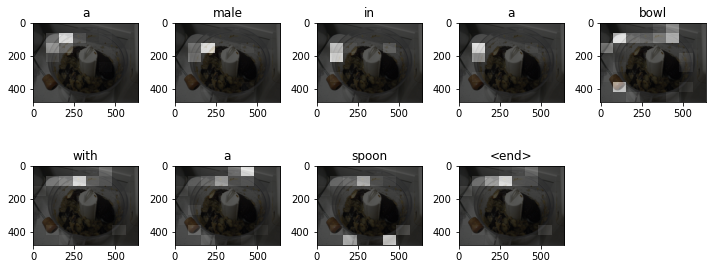

In [38]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Cobalah gambar lain
Di bawah ini kami telah menyediakan metode yang dapat Kita gunakan untuk memberi keterangan pada gambar Anda sendiri dengan model yang baru saja kami latih. Perlu diingat, ini dilatih pada jumlah data yang relatif kecil, dan gambar kita mungkin berbeda dari data pelatihan (jadi bersiaplah untuk hasil yang aneh!)

Prediction Caption: three people are walking across a beach with a man walking out in the sand <end>


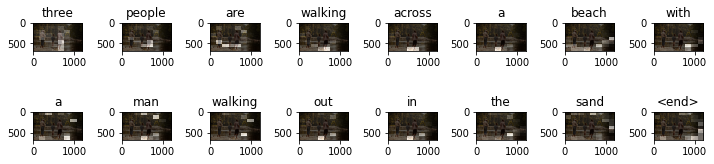

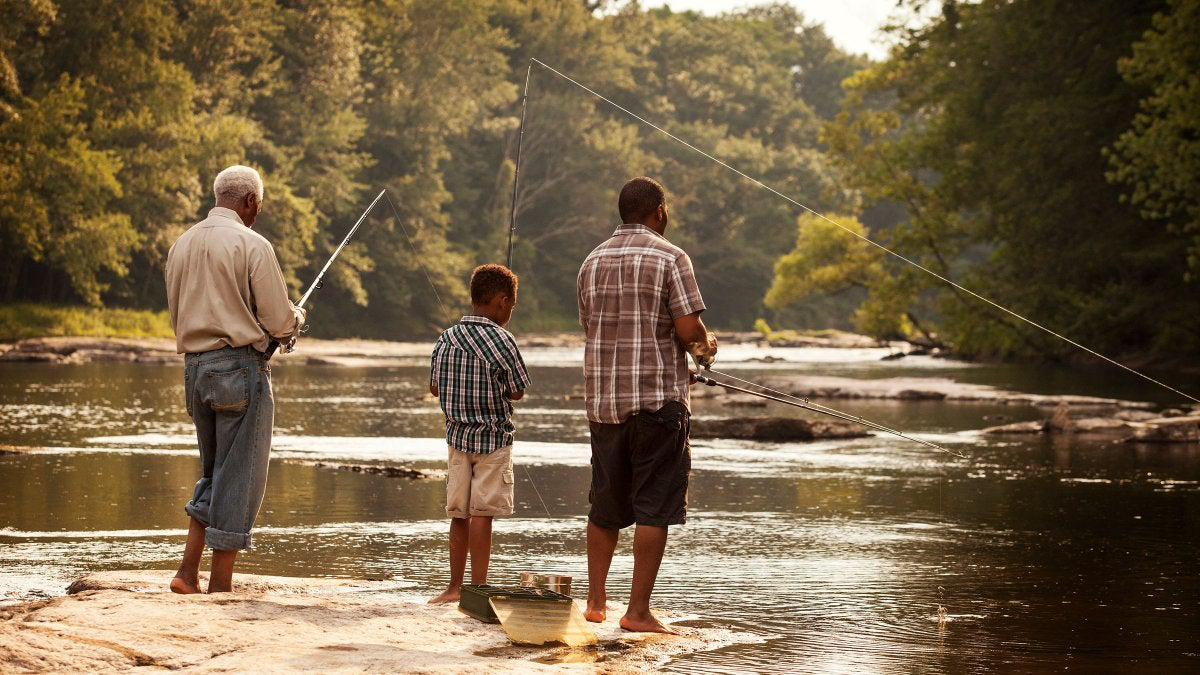

In [39]:
image_url = 'https://www.outsideonline.com/sites/default/files/styles/width_1200/public/2019/04/23/fishing-creek-basics_h.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)